In [42]:
%reset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from numpy import dot
np.random.seed(678)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [43]:
# #############################################################################
# Generate sample data
rng = np.random.RandomState(42)
S = rng.standard_t(1.5, size=(20000, 2))
S[:, 0] *= 2.

# Mix data
A = np.array([[1, 1], [0, 2]])  # Mixing matrix

X = np.dot(S, A.T)  # Generate observations
X_mean = X.mean()
X = X-X_mean #shift mean

In [44]:
# PCA
pca = PCA()
S_pca_ = pca.fit(X).transform(X)
S_pca_ /= S_pca_.std(axis=0)

In [45]:
# ICA
ica = FastICA(random_state=rng)
S_ica_ = ica.fit(X).transform(X)  # Estimate the sources
S_ica_ /= S_ica_.std(axis=0)

In [46]:
def np_sig(x):return  1 /(1+(np.exp(-x)))
def np_tanh(x): return np.tanh(x)
num_epoch = 10000
learning_rate = 0.00003

In [47]:
# Andrew NG's Method
w_sig = np.eye(2)
for iter in range(num_epoch):
    temp = np_sig(dot(X,w_sig))
    temp = 1-2*temp
    w_sig = w_sig + learning_rate * (np.linalg.inv(w_sig.T) + dot(temp.T,X))
S_sig_grad = dot(X,w_sig)
S_sig_grad /= S_sig_grad.std(axis=0)

In [48]:
# Elhabian method
w_tanh_grad = np.eye(2)
for current_iter in range(num_epoch):
    u = dot(X,w_tanh_grad)
    U = np_tanh(u)
    g = np.linalg.inv(w_tanh_grad.T) - (2/len(X)) * dot(X.T,U)
    w_tanh_grad = w_tanh_grad + learning_rate *g
S_tanh_grad = dot(X,w_tanh_grad)
S_tanh_grad /= S_tanh_grad.std(axis=0)

In [49]:
print('Original Data Shape',S.shape)
print('Fast ICA Data Shape',S_ica_.shape)
print('PCA Data Shape',S_pca_.shape)
print('Sigmoid Grad Data Shape',S_sig_grad.shape)
print('Tanh Grad Data Shape',S_tanh_grad.shape)

Original Data Shape (20000, 2)
Fast ICA Data Shape (20000, 2)
PCA Data Shape (20000, 2)
Sigmoid Grad Data Shape (20000, 2)
Tanh Grad Data Shape (20000, 2)


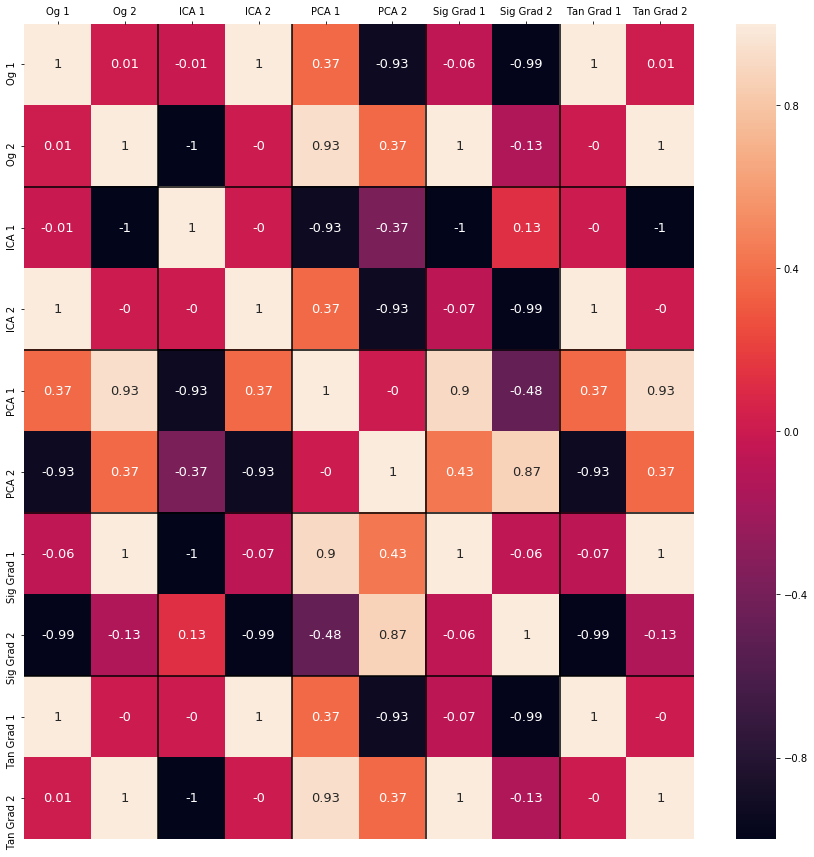

In [55]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(np.hstack((S, S_ica_ , S_pca_,S_sig_grad,S_tanh_grad)),
                 columns=['Og 1','Og 2',
                         'ICA 1','ICA 2',
                         'PCA 1','PCA 2',
                         'Sig Grad 1','Sig Grad 2',
                         'Tan Grad 1','Tan Grad 2',
                         ])
plt.figure(figsize=(15,15))
ax = sns.heatmap(np.around(df.corr(),2),annot=True,annot_kws={"size": 13})
ax.xaxis.tick_top()
ax.vlines([2, 4, 6,8], *ax.get_ylim())
ax.hlines([2, 4, 6,8], *ax.get_xlim())

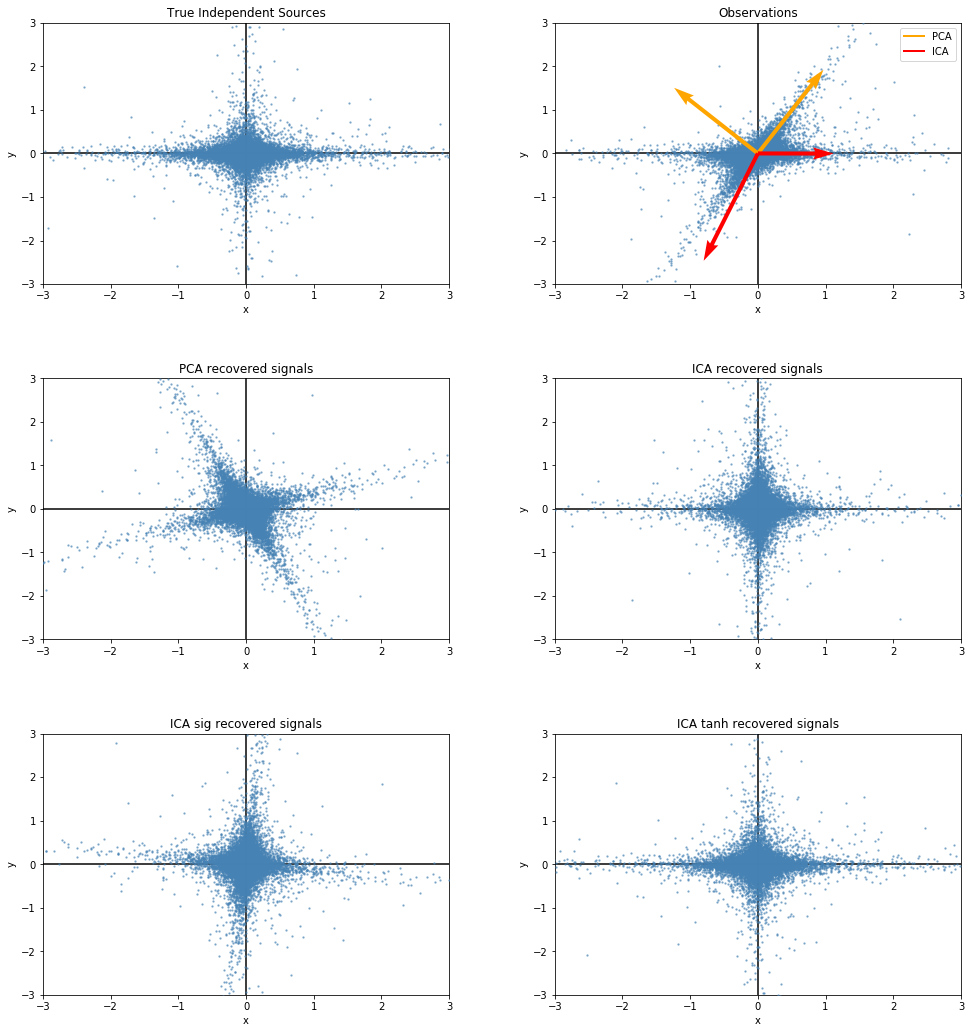

In [56]:
# #############################################################################
# Plot results

def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver(0, 0, x_axis, y_axis, zorder=11, width=0.01, scale=6,
                       color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure(figsize=(15,15))
plt.subplot(3, 2, 1)
plot_samples(S / S.std())
plt.title('True Independent Sources')

axis_list = [pca.components_.T, ica.mixing_]
plt.subplot(3, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)

plt.title('Observations')

plt.subplot(3, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title('PCA recovered signals')

plt.subplot(3, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title('ICA recovered signals')

plt.subplot(3, 2, 5)
plot_samples(S_sig_grad / np.std(S_sig_grad, axis=0))
plt.title('ICA sig recovered signals')

plt.subplot(3, 2, 6)
plot_samples(S_tanh_grad / np.std(S_tanh_grad))
plt.title('ICA tanh recovered signals')

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.show()